In [1]:
import numpy as np

import tensorflow as tf

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm


import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fractaluser/a

In [2]:
from all_models import DavidNet

import run_util


from importlib import reload
reload(run_util)

from run_util import Run

import data_pipeline

reload(data_pipeline)

Using TensorFlow backend.


<module 'data_pipeline' from '/home/fractaluser/Personal/Narahari/eva_research_team4/src/data_pipeline.py'>

In [3]:
data_pipeline.get_data(dataset_name = "CIFAR10")

Downloading..
Preprocessing..
Saving..
saving to numpy pickle


In [4]:
x_train, y_train, x_test, y_test = data_pipeline.load_saved_numpy_data(
    train_path=["../data/train/train_x.npy","../data/train/train_y.npy"],
    test_path=["../data/test/test_x.npy", "../data/test/test_y.npy"])

In [5]:
BATCH_SIZE = 25 #@param {type:"integer"}
MOMENTUM = 0.95 #@param {type:"number"}

MIN_MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 1 #@param {type:"integer"}


MIN_LEARNING_RATE = 0.000001 #@param {type:"number"}

END_LR_SMOOTHING_PERC = 0.15 #@param {type:"number"}

COMMENTS = "Integration tests" #@param {type:"string"}


params_tune = {
    
  "epochs":EPOCHS, 
 
  "batch_size" : BATCH_SIZE,

  "max_lr": LEARNING_RATE,

  "min_lr":MIN_LEARNING_RATE,

  "end_anneal_pc":END_LR_SMOOTHING_PERC,

  "max_mom":MOMENTUM,
 
  "min_mom":MIN_MOMENTUM,
 
  "wd":WEIGHT_DECAY,
  
  "skip_testing_epochs":0,
    
  "batches_per_epoch":100//BATCH_SIZE,
    
  "comments":COMMENTS
}

In [6]:
def tst_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global x_test
  
    global y_test
  
    len_test = x_test[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_test[:30,:,:,:],
                                                   y_test[:30])).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global y_train
    
    global x_train
    
    len_test = x_train[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_train[:50,:,:,:], 
                                        y_train[:50])).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

In [7]:
model_fn = DavidNet

obj = Run()

In [8]:
x = obj.run(model_fn, params_tune, trn_data_supplier, tst_data_supplier)

****training starts****


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
epoch: 1 lr: 0.020000500000000004 train loss: 3.716 train acc:0.219 val loss: 2.164 val acc: 0.000 time:34.590

   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       1          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8   34.593389    0.21875       0.0  0.0005     3.71582   

   test_loss                                               runs  \
0   2.163574  {'epoch': [1], 'time': [34.590840101242065], '...   

              log_time           comments  
0  2019-09-01 07:52:06  Integration tests  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

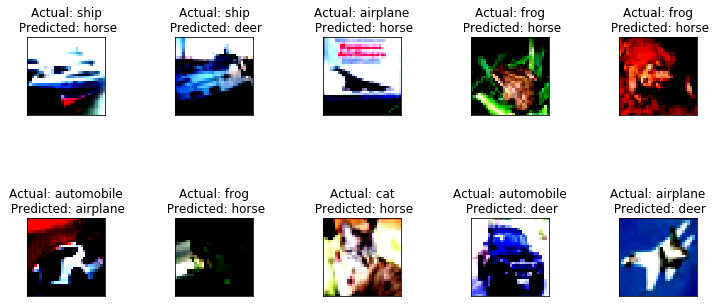

In [9]:
obj.show_missclassified_images(num_images=10, tst_data_supplier=tst_data_supplier)

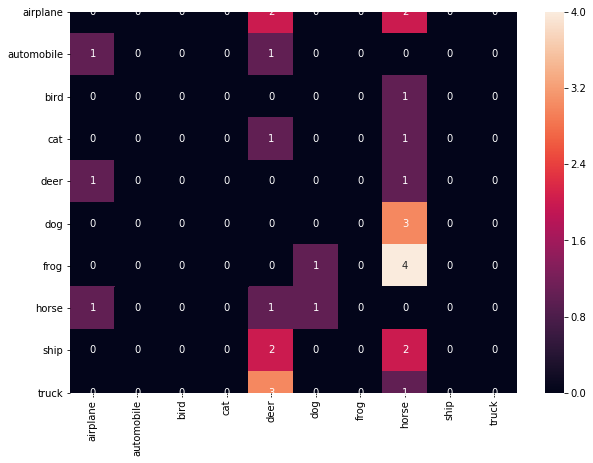

In [10]:
obj.plot_confusion_matrix(tst_data_supplier=tst_data_supplier)

### LR Finder

Creating a separate data supplier for lr finder

In [11]:
def tst_data_supplier_lr(epoch, test_num_batches=2):
 
    batch_size = params_tune["batch_size"]
    
    global x_test
  
    global y_test
  
    sample_idx = np.random.choice(y_test.size, test_num_batches * batch_size, replace=False)

    x_test_lr = x_test[sample_idx, :, :, :]

    y_test_lr = y_test[sample_idx]
    
    len_test = x_test_lr[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_test_lr,
                                                   y_test_lr)).batch(batch_size).prefetch(1)

    return (test_set, len_test)

def trn_data_supplier_lr(epoch, train_num_batches=2):
 
    batch_size = params_tune["batch_size"]
    
    global x_train
  
    global y_train
  
    sample_idx = np.random.choice(y_train.size, train_num_batches * batch_size, replace=False)

    x_train_lr = x_train[sample_idx, :, :, :]

    y_train_lr = y_train[sample_idx]
    
    len_train = x_train_lr[0].shape[0]

    train_set = tf.data.Dataset.from_tensor_slices((x_train_lr,
                                                   y_train_lr)).batch(batch_size).prefetch(1)

    return (train_set, len_train)

running lr_finder


1
****training starts****



2
****training starts****



3
****training starts****


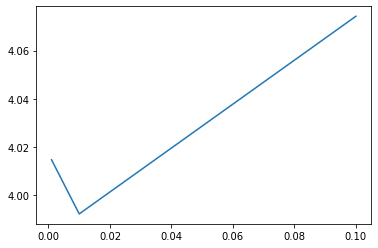

[[0.001, 0.01, 0.1], [4.0146484375, 3.9921875, 4.07421875]]

In [12]:
obj.lr_finder(model_fn, lr_list=[0.001, 0.01, 0.1], tst_data_supplier=tst_data_supplier_lr,
             trn_data_supplier=trn_data_supplier_lr)